# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
train = pd.read_csv("data/calendar_train.csv",parse_dates=[1]).dropna()
test = pd.read_csv("data/calendar_test.csv",parse_dates=[1]).dropna()

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

<function matplotlib.pyplot.show(*args, **kw)>

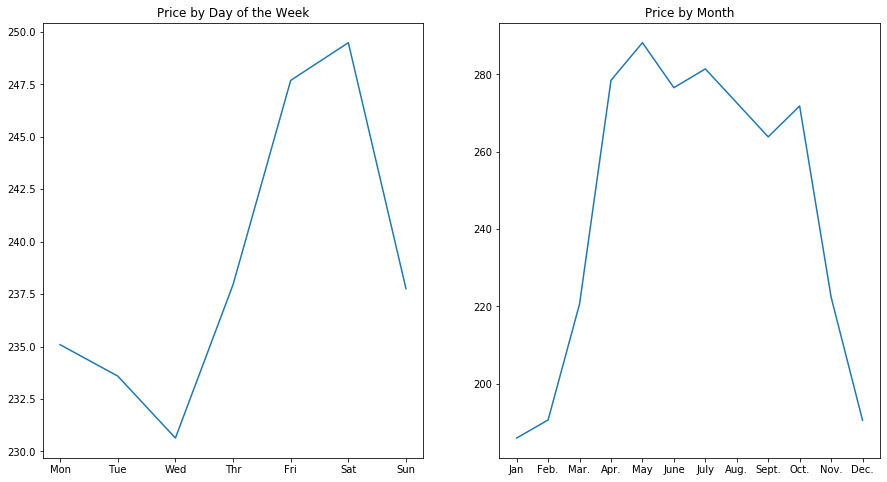

In [4]:
#your code here
train["dayofweek"] = train.date.dt.dayofweek
train["month"] = train.date.dt.month
test["dayofweek"] = test.date.dt.dayofweek
test["month"] = test.date.dt.month
plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(train.groupby('dayofweek')['price'].mean())
plt.xticks(np.arange(7), ['Mon','Tue','Wed','Thr','Fri','Sat','Sun'])
plt.title('Price by Day of the Week')

plt.subplot(122)
plt.plot(train.groupby('month')['price'].mean())
plt.xticks(range(1,13),['Jan','Feb.','Mar.','Apr.','May','June','July','Aug.','Sept.','Oct.','Nov.','Dec.'])
plt.title('Price by Month')
plt.show

### From the left panel we can see that the average price is higher during weekend and lower during weekday. This makes sense as people tend to travel during the weekend when they have free time and stay at home due to woek during weekday. This life pattern is reflected by the price.
### From the right panel we can see that the average price is lower during the winter and higher during the other seasons. This also makes sense as people prefer not to travel during cold days in winter.

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [5]:
#your code here
startday = train.date.min()
train['daydff']=(train.date-startday).dt.days
test['daydff']=(test.date-startday).dt.days

### 1. Polynomials

R2 for traning set with 2 degrees is 0.018488573687428622
R2 for testing set with 2 degrees is 0.019180392770215438
R2 for traning set with 3 degrees is 0.03893294505042644
R2 for testing set with 3 degrees is 0.03875184567550083
R2 for traning set with 5 degrees is 0.04210025470809475
R2 for testing set with 5 degrees is 0.041738186640887354
R2 for traning set with 8 degrees is -0.17019480710237755
R2 for testing set with 8 degrees is -0.15800895739909748


Text(0.5, 1.0, 'testing set')

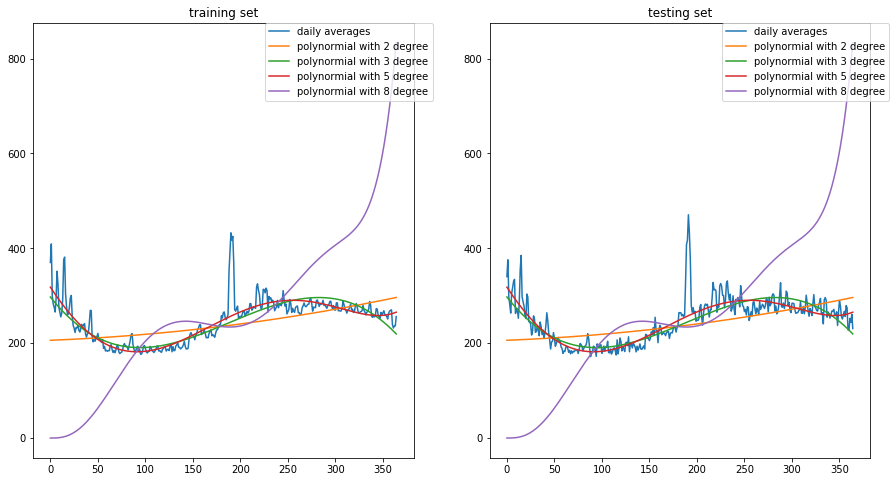

In [6]:
import statsmodels.formula.api as sm
fun = {}
fun[2] = 'price~daydff + np.power(daydff,2)'
components3 = ['np.power(daydff, {})'.format(x) for x in [3]]
fun[3] = 'price~daydff + np.power(daydff,2) + ' + ' + '.join(components3)
components5 = ['np.power(daydff, {})'.format(x) for x in [3,4,5]]
fun[5] = 'price~daydff + np.power(daydff,2) + ' + ' + '.join(components5)
components8 = ['np.power(daydff, {})'.format(x) for x in [3,4,5,6,7,8]]
fun[8] = 'price~daydff + np.power(daydff,2) + ' + ' + '.join(components8)

model = {}
y_train_pred = {}
r2_train = {}
y_test_pred = {}
r2_test = {}
xx = np.linspace(min(train.daydff),max(train.daydff),200)
xx_train = pd.DataFrame(data={"daydff":xx})
xx_test = pd.DataFrame(data={"daydff":xx})
for i in [2,3,5,8]:
    model[i] = sm.ols(formula=fun[i],data=train).fit()
    y_train_pred[i] = model[i].get_prediction(train).summary_frame()['mean']
    r2_train[i] = r2_score(train.price,y_train_pred[i])
    print('R2 for traning set with %s degrees is %s' % (i,r2_train[i]))
    y_test_pred[i] = model[i].get_prediction(test).summary_frame()['mean']
    r2_test[i] = r2_score(test.price,y_test_pred[i])
    print('R2 for testing set with %s degrees is %s' % (i,r2_test[i]))

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(train.groupby('daydff')['price'].mean(),label='daily averages')
for i in [2,3,5,8]:
    plt.plot(xx_train,model[i].get_prediction(xx_train).summary_frame()['mean'],label='polynormial with %s degree' %i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.title('training set')
plt.subplot(122)
plt.plot(test.groupby('daydff')['price'].mean(),label='daily averages')
for i in [2,3,5,8]:
    plt.plot(xx_test,model[i].get_prediction(xx_test).summary_frame()['mean'],label='polynormial with %s degree' %i)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
plt.title('testing set')


_your answer here_
### Please see the output above for R2 of polynomial with different degrees.

### 2. Degree 8 oddity
_your answer here_
### As the degree gets higher, the power terms would explode for large values and vanish for small values, which leads to the oddity of polynomial with 8 degree (eg. for the term with fifth power, the term \beta_5 * 350^4=4.3*10^5). Still, the model does not fit the data well. And the coefficients of models indeed change a lot.  This phenomenon is similar to the so-called Runge's Phenomenon. When a function is approximated with polynomials, we normally assume the reminder of the approximation to be close to 0. However, in some situations, the reminder of the approximation, especially on the edge of x range, does not converge to 0. With the high degree of polynomial, the reminder can not be ignored and thus introduces significant bias. To address this, one can use piece-wise polynomial or use more interpolation points near the edge or choose polynomials with a moderate degree so that power terms do not go wide for extreme values or turn to other smoothing methods like splines. 

In [7]:
model[8].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -0.170
Model:                            OLS   Adj. R-squared:                 -0.170
Method:                 Least Squares   F-statistic:                    -8996.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               1.00
Time:                        23:07:24   Log-Likelihood:            -2.0836e+06
No. Observations:              309288   AIC:                         4.167e+06
Df Residuals:                  309282   BIC:                         4.167e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.821e-09      4e-11    170.633      0.000    6.74e-09     6.9e-09
daydff              -8.678e-07   5.09e-09   -170.632      0.000   -8.78e-07   -8.58e-07
np.power(daydff, 2)  2.805e-05   1.64e-07    170.636      0.000    2.77e-05    2.84e-05
np.power(daydff, 3)     0.0011   6.36e-06    170.640      0.000       0.001       0.001
np.power(daydff, 4) -1.522e-05   1.07e-07   -142.019      0.000   -1.54e-05    -1.5e-05
np.power(daydff, 5)  8.211e-08   6.56e-10    125.171      0.000    8.08e-08    8.34e-08
np.power(daydff, 6) -1.973e-10   1.73e-12   -113.880      0.000   -2.01e-10   -1.94e-10
np.power(daydff, 7)  1.765e-13   1.67e-15    105.591      0.000    1.73e-13     1.8e-13
np.power(daydff, 8)  1.624e-18    1.1e-19     14.811      0.000    1.41e-18    1.84e-18
==============================================================================
Omnibus:                   202415.200   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9466729.290
Skew:                           2.553   Prob(JB):                         0.00
Kurtosis:                      29.618   Cond. No.                     2.07e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

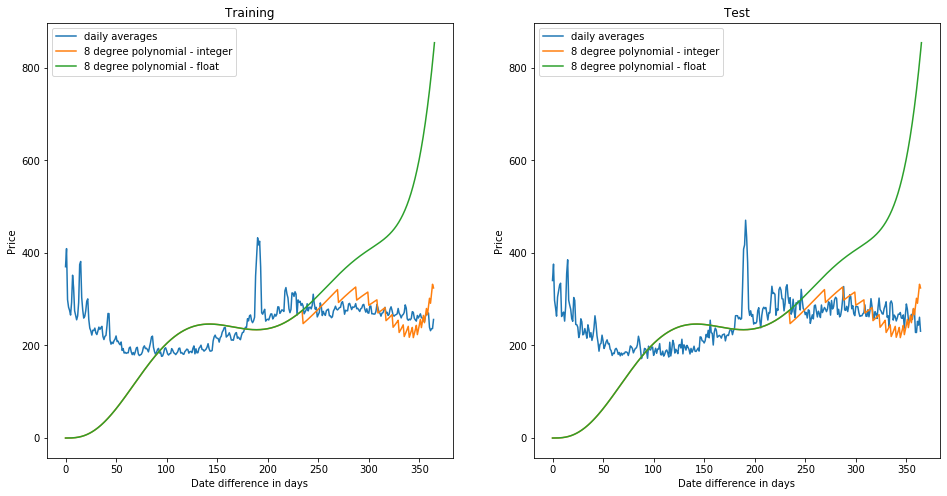

In [8]:
#The above 8-degree model is using integer data of training set. I got different prediction when I use integer and float to predict outcome.
date_pred = pd.DataFrame({"daydff":np.arange(np.min(train.daydff),np.max(train.daydff)+1,1)})
date_pred2 = pd.DataFrame({"daydff":np.arange(np.min(train.daydff),np.max(train.daydff)+1,.1)})#using float to predict

fig, axes=plt.subplots(1,2, figsize=(16,8))

axes[0].plot(train.groupby('daydff')['price'].mean(),label='daily averages')
#axes[0].plot(date_pred,model_2.get_prediction(date_pred).summary_frame()['mean'],label='2 degree polynomial')
#axes[0].plot(date_pred,model_3.get_prediction(date_pred).summary_frame()['mean'],label='3 degree polynomial')
#axes[0].plot(date_pred,model_5.get_prediction(date_pred).summary_frame()['mean'],label='5 degree polynomial')
axes[0].plot(date_pred,model[8].get_prediction(date_pred).summary_frame()['mean'],label='8 degree polynomial - integer')
axes[0].plot(date_pred2,model[8].get_prediction(date_pred2).summary_frame()['mean'],label='8 degree polynomial - float')
axes[0].set_title('Training')
axes[0].set_ylabel('Price')
axes[0].set_xlabel('Date difference in days')
axes[0].legend()

axes[1].plot(test.groupby('daydff')['price'].mean(),label='daily averages')
#axes[1].plot(date_pred,model_2.get_prediction(date_pred).summary_frame()['mean'],label='2 degree polynomial')
#axes[1].plot(date_pred,model_3.get_prediction(date_pred).summary_frame()['mean'],label='3 degree polynomial')
#axes[1].plot(date_pred,model_5.get_prediction(date_pred).summary_frame()['mean'],label='5 degree polynomial')
axes[1].plot(date_pred,model[8].get_prediction(date_pred).summary_frame()['mean'],label='8 degree polynomial - integer')
axes[1].plot(date_pred2,model[8].get_prediction(date_pred2).summary_frame()['mean'],label='8 degree polynomial - float')
axes[1].set_title('Test')
axes[1].set_ylabel('Price')
axes[1].set_xlabel('Date difference in days')
axes[1].legend()

plt.show()

We also notice that The 8-degree model can be very strange (jaggy when using integer date difference to predict outcome). It may be due to int/float percision problems, since 8-degree of three digits number is very large and may overflow. 

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In [9]:
#your code here
candidate_smoothings = [0, 1, 3, 5, 10, 20, 200, 1e6]

kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(train.daydff)):
    train_df = train.iloc[train_index,:]
    test_df = train.iloc[test_index,:]
    for j,cur_smoothing in enumerate(candidate_smoothings):
        gam = LinearGAM(lam=candidate_smoothings[j]).fit(train_df.daydff.values.reshape(-1,1), train_df.price)
        scores[i,j] = r2_score(test_df.price, gam.predict(test_df.daydff))
    
best_lambda = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]
print("the best smoothing penalty is %s"%best_lambda)

the best smoothing penalty is 1


R2 for training set is 0.04496330963343287
R2 for testing set is 0.04479632815240109
The line of lambda=0 overlaps with the line of best lambda=1.


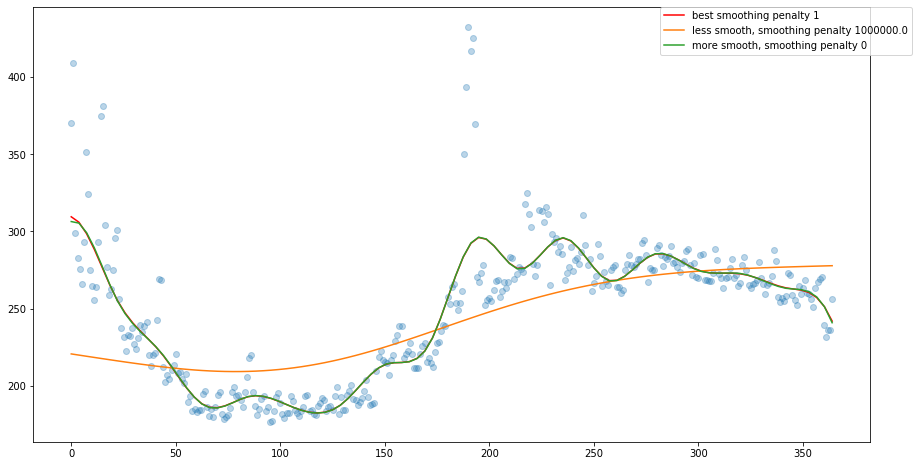

In [10]:
gam_best = LinearGAM(lam=best_lambda).fit(train.daydff.values.reshape(-1,1), train.price)
scores_train_best = r2_score(train.price, gam_best.predict(train.daydff))
print('R2 for training set is %s' % scores_train_best)
scores_test_best = r2_score(test.price, gam_best.predict(test.daydff))
print('R2 for testing set is %s' % scores_test_best)
gam_more = LinearGAM(lam=max(candidate_smoothings)).fit(train.daydff.values.reshape(-1,1), train.price)
gam_less = LinearGAM(lam=min(candidate_smoothings)).fit(train.daydff.values.reshape(-1,1), train.price)
XX = gam.generate_X_grid(term=0)
plt.figure(figsize=(15, 8))
plt.plot(train.groupby('daydff')['price'].mean(),'o',alpha=0.3);
plt.plot(XX, gam_best.predict(XX),'r',label='best smoothing penalty %s' %best_lambda)
plt.plot(XX, gam_more.predict(XX),label='less smooth, smoothing penalty %s' %max(candidate_smoothings))
plt.plot(XX, gam_less.predict(XX),label='more smooth, smoothing penalty %s' %min(candidate_smoothings))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
print("The line of lambda=0 overlaps with the line of best lambda=1.")

### 4. Effects of parameters
_your answer here_
### The best performance is achieved by smoothing spline with lamba 1, based on r2 score,. Incereasing the degree will alter the fitted curve more curvy and improve the R2 (reduce bias), however, too large degree would result in overfitting and explosion of terms with high power (icnrease variance), rendering the fitted model invalide. Incresing the smoothing penalty would get a smoother curve and lower R2.  Tuning smoothness penalty can balance data fitness and curveness of the fitted line. It helps avoid too complex curved fitted lines and mitigate overfitting, again a trade-off  between variance and bias.

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [11]:
#your code here
weekend1 = np.zeros(train.shape[0])
weekend1[train.dayofweek>3] = 1
weekend1[train.dayofweek>5] = 0
train['weekend'] = weekend1
weekend2 = np.zeros(test.shape[0])
weekend2[test.dayofweek>3] = 1
weekend2[test.dayofweek>5] = 0
test['weekend'] = weekend2
x_train = train[["daydff","weekend"]]
x_test = test[["daydff","weekend"]]
mygam = LinearGAM(s(0)+f(1),lam=best_lambda).fit(x_train, train.price)
scores_train_best = r2_score(train.price, mygam.predict(x_train))
print('R2 for training set is %s' % scores_train_best)
scores_test_best = r2_score(test.price, mygam.predict(x_test))
print('R2 for testing set is %s' % scores_test_best)

R2 for training set is 0.04611729425912747
R2 for testing set is 0.046157511098090076


### R2 increses in both traning and testing set by including weekend indicator.

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [12]:
#your code here
test.groupby('date')['price'].mean().sort_values(ascending=False)[0:10]

date
2018-04-15    470.674107
2018-04-16    434.401914
2018-04-14    417.286344
2018-04-13    408.186207
2017-10-21    385.142857
2018-04-17    379.331169
2017-10-07    375.779412
2017-10-20    354.943396
2017-10-06    340.312500
2017-10-14    334.520548
Name: price, dtype: float64

_your answer here_
### There are big events during these days, they are 2018 Boston Marathon (April 16th, it was also the Patriot's Day of M) and American Society of Anesthesiologists 2017 Annual Meeting (Oct. 21-23, 18000 attendees). Those big events would attract more tourists and a larger demand for housing than usual. Hence, the price would go up as a response to the larger demand. The other days with high prices may due to random or other smaller events. Another possible explanation may for these days may be that they are weekends in a nice season. 

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

/Users/xuehao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/Users/xuehao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


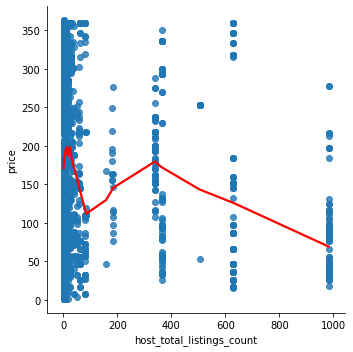

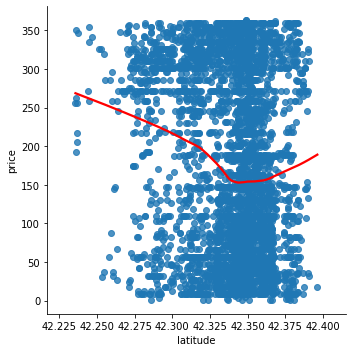

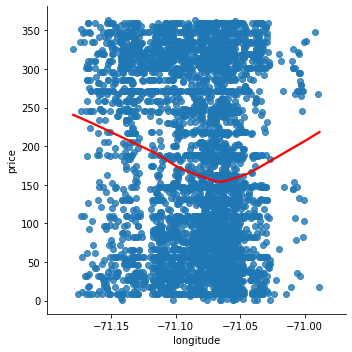

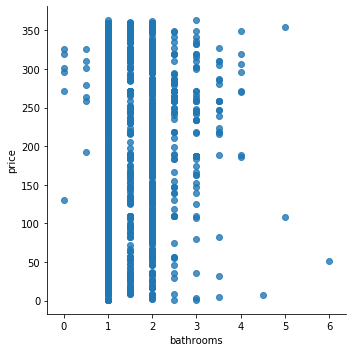

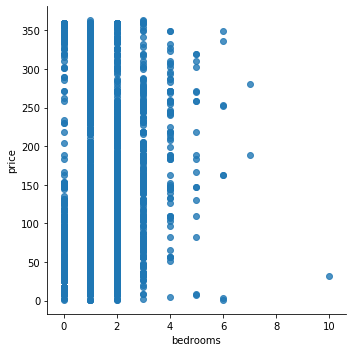

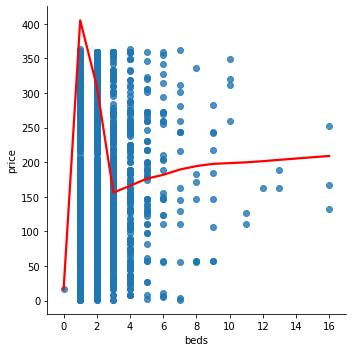

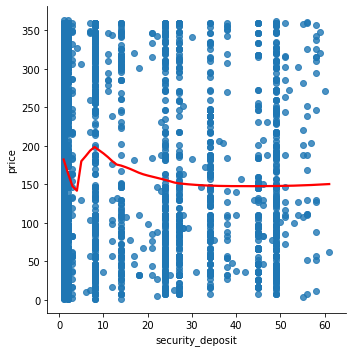

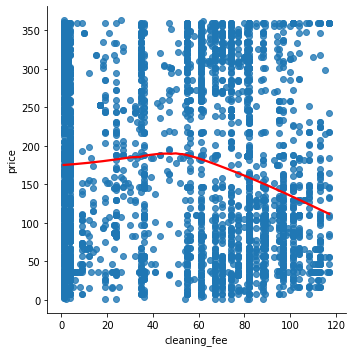

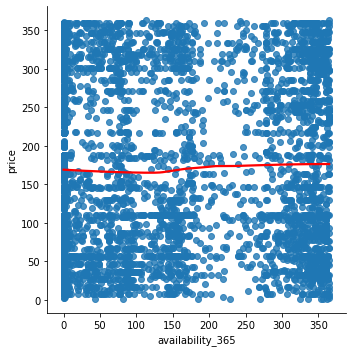

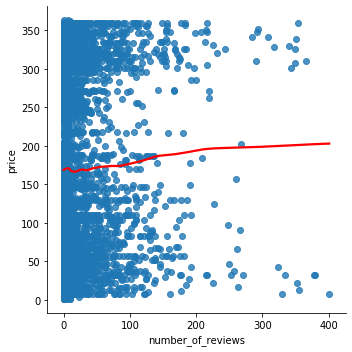

In [13]:
#your code here
# from statsmodels.nonparametric.smoothers_lowess import lowess
train = pd.read_csv("data/listings_train.csv")
test = pd.read_csv("data/listings_test.csv")
X_train = train
y_train = train.price
X_test = test
y_test = test.price
for col in list(train.columns):
    if col not in ['room_type', "price"]:
        sns.lmplot(x=col, y="price", data=train,lowess=True,line_kws={'color': 'red'});

_your answer here_
### According to lowess, it seems that there exits non-linear relationship between price and bathrooms/bedrooms/beds/host total listings count/latitude/longitude/cleanning fee/security deposit.

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [14]:
#your code here
from sklearn import linear_model
X_train_ = pd.get_dummies(X_train, columns=["room_type"])
X_train_.columns = X_train_.columns.str.replace(' ', '_').str.replace("/", "_")
X_test_ = pd.get_dummies(X_test, columns=["room_type"])
X_test_.columns = X_test_.columns.str.replace(' ', '_').str.replace("/", "_")
regr = linear_model.LinearRegression()
regr.fit(X_train_[X_train_.columns.difference(["price"])], X_train["price"])
y_train_pred = regr.predict(X_train_[X_train_.columns.difference(["price"])])
r2_train = r2_score(y_train,y_train_pred)
print('R2 for traning set of linear regression is %s' % (r2_train))
y_test_pred = regr.predict(X_test_[X_train_.columns.difference(["price"])])
r2_test = r2_score(y_test,y_test_pred)
print('R2 for test set of linear regression is %s' % (r2_test))
#polynomial_features= PolynomialFeatures(degree=3)
#X_train_poly = polynomial_features.fit_transform(X_train[])
colnames = list(X_train.columns.difference(['room_type',"price"]))
comp = []
for col in colnames:
    comp += ["np.power(%s,2) + np.power(%s,3)" %(col,col)]
myformula3 = "price~" + "+".join(comp) + "+" + "+".join(X_train_.columns.difference(['price']))
lm3 = sm.ols(formula=myformula3,data=X_train_).fit()
Y_train_pred = lm3.get_prediction(X_train_).summary_frame()['mean']
r2_train = r2_score(X_train_.price,Y_train_pred)
print('R2 for traning set with degrees 3 is %s' % r2_train)
Y_test_pred = lm3.get_prediction(X_test_).summary_frame()['mean']
r2_test = r2_score(X_test_.price,Y_test_pred)
print('R2 for testing set with degrees 3 is %s' % r2_test)

R2 for traning set of linear regression is 0.24941504849625185
R2 for test set of linear regression is 0.18479127231125003
R2 for traning set with degrees 3 is 0.2706476944226416
R2 for testing set with degrees 3 is 0.23783233242483348


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_
### GAM can better capture the potential nonlinear relationship between the price and features of interests without prior assumption of the underlying relationship while the flexibility of power function is limited. Also, GAM can use knots to better fit the data, while linear and polynomial regression fail to exploit this piecewise relationship.

In [15]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here
le = LabelEncoder()
le.fit(train.room_type)
x_train_ = train[train.columns.difference(["price","room_type"])].copy()
x_test_ = test[test.columns.difference(["price","room_type"])].copy()
x_train_['room_type'] = le.transform(train.room_type)
x_test_['room_type'] = le.transform(test.room_type)
x_train = x_train_.values
x_test = x_test_.values
y_train = train.price
y_test = test.price

gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+s(8)+s(9)+f(10))
gam.gridsearch(x_train,y_train)
scores_train_best = r2_score(y_train, gam.predict(x_train))
print('R2 for training set is %s' % scores_train_best)
scores_test_best = r2_score(y_test, gam.predict(x_test))
print('R2 for testing set is %s' % scores_test_best)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


R2 for training set is 0.2791363201787853
R2 for testing set is 0.24136711284915846
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     56.9315
Link Function:                     IdentityLink Log Likelihood:                                -44110.0522
Number of Samples:                         4370 AIC:                                            88335.9674
                                                AICc:                                           88337.5512
                                                GCV:                                             9882.7409
                                                Scale:                                           9651.2621
                                                Pseudo R-Squ

/Users/xuehao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



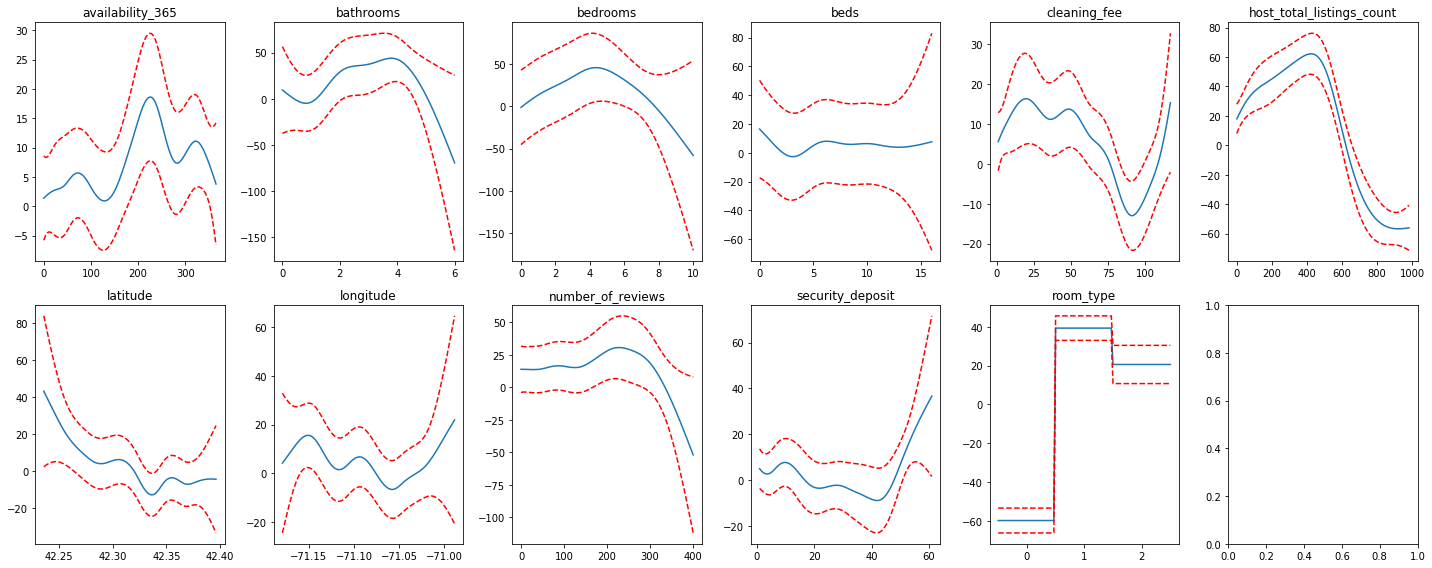

In [16]:
#your code here
fig, axs = plt.subplots(2,6,figsize=(20,8))
names = x_train_.columns
for i, ax in enumerate(axs.flatten()):
    if i < x_train_.shape[1]:
        XX = gam.generate_X_grid(term=i)
        plt.subplot(ax)
        plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        plt.title(names[i])
plt.tight_layout()

### The price is higher for housing with lower latitude, in other words, housing in southern Boston is slightly higher (probabily closer to downtown). Housing in eastern Boston is also higher, because it is closer to the sea. Entire home/apt is the chpeasted type of room while the private room is the most expensive. There is also a negative correlation between number of reviews and price. It is likely that cheaper room would attract more customers and therefore more reviews would be left. Moreover, it seems the there is a non-linear relationship between host total listings cout and price: The price goes up then drops down as the host total listing count gets larger.

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_

### Generally, the day of the week and season would influence the price. The price is higher in weekends and warmer seasons. The price would also go up if there are big events attracting many tourists. Housing in southern or eastern Boston is generally more expensive. Entire home/apt is the cheapest type of room. 